In [28]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [12]:
import pandas as pd
import numpy as np

# Load data
data = pd.read_csv("used_car_sales.csv")

# Clean column names (standardization)
data.columns = data.columns.str.strip()

print("Columns:")
print(data.columns.tolist())

# Select relevant columns (REAL NAMES)
data_sample = data.sample(n=1500, random_state=42)

print("Original size:", data.shape)
print("Sample size:", data_sample.shape)

data = data_sample

# Select relevant columns
data = data[
    [
        "Price-$",
        "Manufactured Year",
        "Mileage-KM",
        "Energy",
        "Gearbox",
        "Car Type",
        "Engine Power-HP"
    ]
]

# Rename columns (for convenience)
data.rename(columns={
    "Price-$": "price",
    "Manufactured Year": "year",
    "Mileage-KM": "mileage_km",
    "Energy": "fuel",
    "Gearbox": "gearbox",
    "Car Type": "car_type",
    "Engine Power-HP": "engine_hp"
}, inplace=True)

# Cleaning
data.dropna(inplace=True)
data = data[data["price"] > 0]
data = data[data["mileage_km"] > 0]
data = data[data["year"] > 1990]

data.drop_duplicates(inplace=True)

print("Shape after cleaning:", data.shape)


Columns:
['ID', 'Distributor Name', 'Location', 'Car Name', 'Manufacturer Name', 'Car Type', 'Color', 'Gearbox', 'Number of Seats', 'Number of Doors', 'Energy', 'Manufactured Year', 'Price-$', 'Mileage-KM', 'Engine Power-HP', 'Purchased Date', 'Car Sale Status', 'Sold Date', 'Purchased Price-$', 'Sold Price-$', 'Margin-%', 'Sales Agent Name', 'Sales Rating', 'Sales Commission-$', 'Feedback']
Original size: (10000, 25)
Sample size: (1500, 25)
Shape after cleaning: (1500, 7)


/tmp/ipython-input-2881555407.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns={
/tmp/ipython-input-2881555407.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


In [13]:
from sklearn.ensemble import IsolationForest

num_cols = ["price", "year", "mileage_km", "engine_hp"]

iso = IsolationForest(
    contamination=0.05,
    random_state=42
)

data["outlier"] = iso.fit_predict(data[num_cols])

print("Outliers detected:", (data["outlier"] == -1).sum())

data = data[data["outlier"] == 1]
data.drop(columns=["outlier"], inplace=True)

print("Shape after outlier removal:", data.shape)


Outliers detected: 75
Shape after outlier removal: (1425, 7)


In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Encode categorical features
data_encoded = pd.get_dummies(
    data,
    columns=["fuel", "gearbox", "car_type"],
    drop_first=True
)

# Scaling
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_encoded)

# KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
data["cluster"] = kmeans.fit_predict(scaled_data)

print(data.head())

# Cluster summary
print("\nCluster Summary:")
print(data.groupby("cluster").mean(numeric_only=True))


      price  year  mileage_km      fuel    gearbox   car_type  engine_hp  \
6252   6200  2023       43139    Diesel  Automatic  Hatchback        120   
4684   7300  2021       80457    Hybrid  Automatic  Hatchback        103   
1731   8100  2019       62489    Diesel     Manual        SUV        120   
4742   9800  2016       87903  Electric  Automatic        SUV        200   
4521   7600  2023       46711    Petrol     Manual        SUV        130   

      cluster  
6252        1  
4684        3  
1731        0  
4742        0  
4521        0  

Cluster Summary:
               price         year    mileage_km   engine_hp
cluster                                                    
0        8646.252285  2019.553931  45837.106033  167.586837
1        6517.821782  2019.306931  44334.564356  119.465347
2        7544.174757  2019.655340  44502.606796  107.208738
3        7707.860262  2019.628821  45766.956332  120.834061
4        8133.609959  2019.473029  46797.120332  148.962656


In [32]:
from mlxtend.frequent_patterns import apriori, association_rules

# Discretization
data_ar = data.copy()

data_ar["price_cat"] = pd.qcut(data_ar["price"], 3, labels=["Low", "Mid", "High"])
data_ar["mileage_cat"] = pd.qcut(data_ar["mileage_km"], 3, labels=["Low", "Mid", "High"])
data_ar["year_cat"] = pd.qcut(data_ar["year"], 3, labels=["Old", "Mid", "New"])

ar_data = data_ar[
    ["price_cat", "mileage_cat", "year_cat", "fuel", "gearbox", "car_type"]
]

ar_encoded = pd.get_dummies(ar_data)

frequent_itemsets = apriori(
    ar_encoded,
    min_support=0.05,
    use_colnames=True
)

rules = association_rules(
    frequent_itemsets,
    metric="confidence",
    min_threshold=0.6
)

print(rules[["antecedents", "consequents", "support", "confidence", "lift"]].head())


                             antecedents      consequents   support  \
0                          (fuel_Petrol)  (price_cat_Low)  0.157193   
1                   (car_type_Hatchback)  (price_cat_Low)  0.211930   
2                       (price_cat_High)   (car_type_SUV)  0.181754   
3         (mileage_cat_Low, fuel_Petrol)  (price_cat_Low)  0.055439   
4  (car_type_Hatchback, mileage_cat_Low)  (price_cat_Low)  0.072281   

   confidence      lift  
0    0.622222  1.685678  
1    0.700696  1.898274  
2    0.605140  1.745597  
3    0.686957  1.861051  
4    0.682119  1.847947  


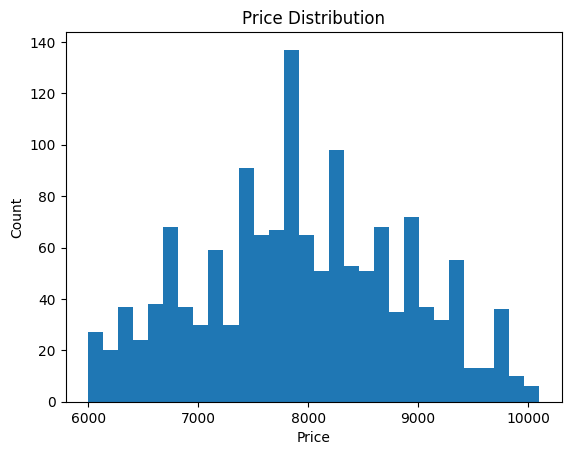

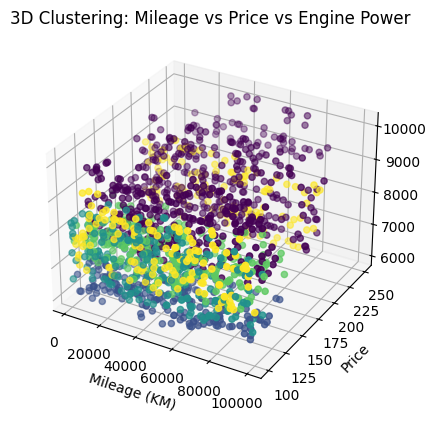

In [33]:
import matplotlib.pyplot as plt

# Price distribution
plt.figure()
plt.hist(data["price"], bins=30)
plt.xlabel("Price")
plt.ylabel("Count")
plt.title("Price Distribution")
plt.show()

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    data["mileage_km"],
    data["engine_hp"],
    data["price"],
    c=data["cluster"]
)

ax.set_xlabel("Mileage (KM)")
ax.set_ylabel("Price")
ax.set_zlabel("Engine Power (HP)")
ax.set_title("3D Clustering: Mileage vs Price vs Engine Power")

plt.show()

